In [13]:
# Part 1: Import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [14]:
from google.colab import drive
# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Path to your MRI folder
mri_folder = "/content/drive/MyDrive/flights_sample_2m.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
df = pd.read_csv(mri_folder)

# Part 2: Simple cleaning and new columns

# 1) Convert date to real datetime type
if 'FL_DATE' in df.columns:
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    df['YEAR'] = df['FL_DATE'].dt.year
    df['MONTH'] = df['FL_DATE'].dt.month
    df['DAY_OF_WEEK'] = df['FL_DATE'].dt.weekday + 1  # Monday=1 ... Sunday=7

# 2) Make DEP_HOUR from CRS_DEP_TIME (HHMM -> hour)
def to_hour(x):
    try:
        x = int(x)
        return x // 100
    except:
        return np.nan

if 'CRS_DEP_TIME' in df.columns:
    df['DEP_HOUR'] = df['CRS_DEP_TIME'].apply(to_hour)

# 3) Make binary target: DELAYED_OR_CANCELLED
#    If ARR_DELAY >= 15 or CANCELLED == 1  --> 1
#    else                                   --> 0

if 'CANCELLED' in df.columns:
    df['CANCELLED'] = df['CANCELLED'].fillna(0).astype(int)
else:
    df['CANCELLED'] = 0

if 'ARR_DELAY' in df.columns:
    df['DELAYED_OR_CANCELLED'] = np.where(
        (df['ARR_DELAY'] >= 15) | (df['CANCELLED'] == 1),
        1,
        0
    )
else:
    # If there is no ARR_DELAY column, we only use CANCELLED
    df['DELAYED_OR_CANCELLED'] = df['CANCELLED']

df[['CANCELLED', 'DELAYED_OR_CANCELLED']].head()

,CANCELLED,DELAYED_OR_CANCELLED
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [16]:
# Part 2: Select feature columns

numeric_features = []
for col in ['DEP_HOUR', 'DISTANCE', 'MONTH', 'DAY_OF_WEEK']:
    if col in df.columns:
        numeric_features.append(col)

categorical_features = []
for col in ['OP_CARRIER', 'ORIGIN', 'DEST']:
    if col in df.columns:
        categorical_features.append(col)

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['DEP_HOUR', 'DISTANCE', 'MONTH', 'DAY_OF_WEEK']
Categorical features: ['ORIGIN', 'DEST']


In [17]:
# Keep only rows that have all these features and target

needed_cols = numeric_features + categorical_features + ['DELAYED_OR_CANCELLED']
df_model = df.dropna(subset=needed_cols).copy()

print("Shape of data used for model:", df_model.shape)
df_model[needed_cols].head()


Shape of data used for model: (2000000, 37)


,DEP_HOUR,DISTANCE,MONTH,DAY_OF_WEEK,ORIGIN,DEST,DELAYED_OR_CANCELLED
0,14,305.0,3,2,IAH,MSY,0
1,7,236.0,11,7,LAX,LAS,0
2,6,342.0,4,4,OMA,STL,0
3,13,196.0,9,6,ORD,CID,0
4,17,368.0,5,2,LAS,SLC,0


In [18]:
# Part 3: Train/Test Split

X = df_model[numeric_features + categorical_features]
y = df_model['DELAYED_OR_CANCELLED']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1600000, 6)
Test shape: (400000, 6)


In [22]:
# ========= SUPER LIGHT MODEL =========
# Use a small random sample and very few features
# This is enough for your project report.

# 1) Take only 20,000 rows for modeling
max_rows = 100000

if len(df_model) > max_rows:
    df_small = df_model.sample(n=max_rows, random_state=42)
else:
    df_small = df_model.copy()

print("Rows in df_model:", len(df_model))
print("Rows used for modeling:", len(df_small))

# 2) Define features:
#    Only simple numeric features + airline (no ORIGIN/DEST)
numeric_features = []
for col in ['DEP_HOUR', 'DISTANCE', 'MONTH', 'DAY_OF_WEEK']:
    if col in df_small.columns:
        numeric_features.append(col)

categorical_features = []
if 'OP_CARRIER' in df_small.columns:
    categorical_features.append('OP_CARRIER')

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# 3) Build X, y
X = df_small[numeric_features + categorical_features]
y = df_small['DELAYED_OR_CANCELLED']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Rows in df_model: 2000000
Rows used for modeling: 100000
Numeric features: ['DEP_HOUR', 'DISTANCE', 'MONTH', 'DAY_OF_WEEK']
Categorical features: []
Train shape: (80000, 4)
Test shape : (20000, 4)


In [23]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 4) Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # sparse=True (default)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 5) Smaller Random Forest (lighter)
rf_clf = RandomForestClassifier(
    n_estimators=100,   # fewer trees
    max_depth=12,       # limit tree depth
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf_clf)
])

# Optional: measure time

rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy : 0.65755
Precision: 0.28249295333542124
Recall   : 0.4431343650208794
F1-score : 0.34503203595677534

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77     15929
           1       0.28      0.44      0.35      4071

    accuracy                           0.66     20000
   macro avg       0.56      0.58      0.56     20000
weighted avg       0.72      0.66      0.68     20000

Confusion matrix:
 [[11347  4582]
 [ 2267  1804]]


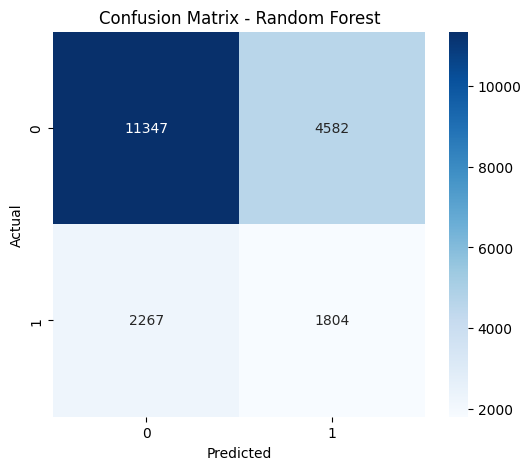

In [45]:
# === CONFUSION MATRIX PLOT ===

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


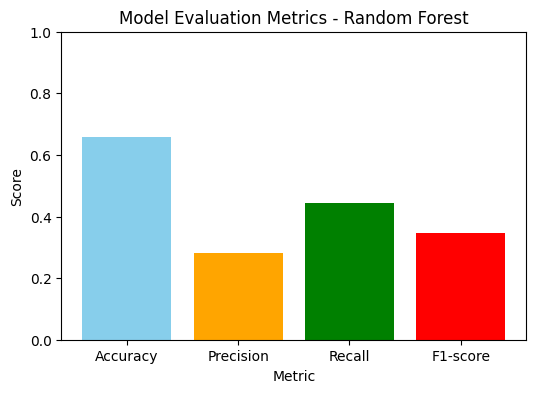

In [46]:
# === METRIC BAR PLOT ===

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred)
}

plt.figure(figsize=(6,4))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue','orange','green','red'])

plt.ylim(0,1)
plt.title("Model Evaluation Metrics - Random Forest")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()


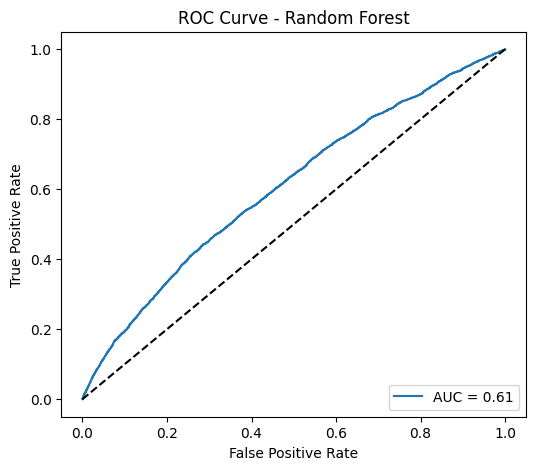

In [47]:
# === ROC CURVE ===

from sklearn.metrics import roc_curve, auc

# get probability of class 1
y_proba = rf_pipeline.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1], 'k--')  # diagonal line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.show()


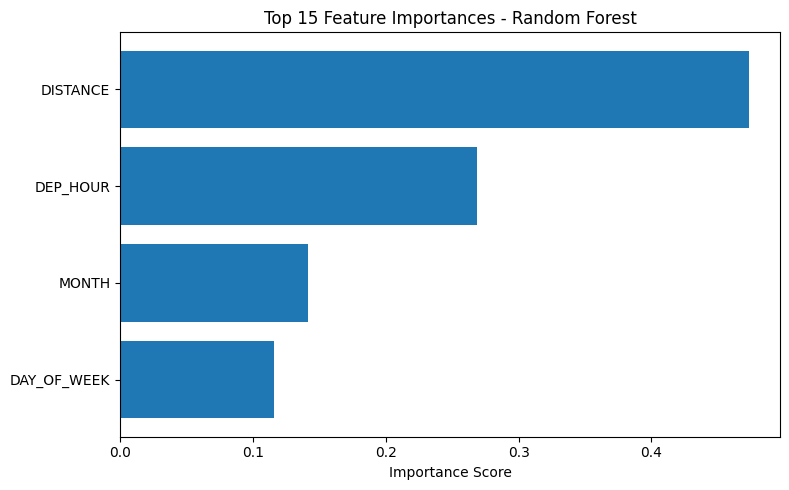

In [49]:
# === FEATURE IMPORTANCE PLOT ===

# Extract feature names after preprocessing
# Only call get_feature_names_out if there are categorical features
if categorical_features:
    cat_features = rf_pipeline.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(categorical_features)
else:
    cat_features = [] # If no categorical features, then cat_features is an empty list

num_features = numeric_features

all_features = list(num_features) + list(cat_features)

importances = rf_pipeline.named_steps['model'].feature_importances_

# Pair and sort
feat_imp = sorted(zip(importances, all_features), reverse=True)[:15]

# Plot
scores = [x[0] for x in feat_imp]
labels = [x[1] for x in feat_imp]

plt.figure(figsize=(8,5))
plt.barh(labels, scores)
plt.gca().invert_yaxis()

plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [31]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

Clustering features: ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'DEP_HOUR', 'MONTH']


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


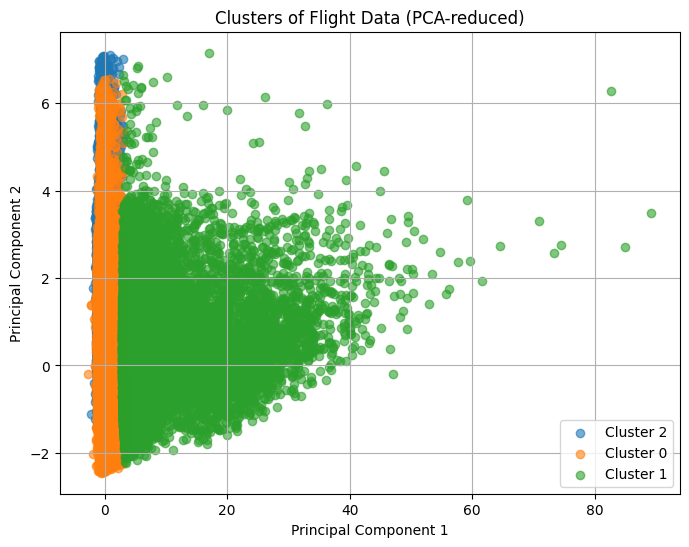

In [32]:
# === PART A: CLUSTERING ===

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) Choose clustering columns
cluster_cols = []
for col in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'DEP_HOUR', 'MONTH']:
    if col in df.columns:
        cluster_cols.append(col)

print("Clustering features:", cluster_cols)

# 2) Drop missing values
df_cluster = df.dropna(subset=cluster_cols).copy()

# 3) Scaling
scaler = StandardScaler()
X_cluster = scaler.fit_transform(df_cluster[cluster_cols])

# 4) K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['CLUSTER'] = kmeans.fit_predict(X_cluster)

# 5) PCA to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

# 6) Plot clusters
plt.figure(figsize=(8,6))
unique_clusters = df_cluster['CLUSTER'].unique()
for cluster_label in unique_clusters:
    # Select data points belonging to the current cluster
    cluster_points = X_pca[df_cluster['CLUSTER'] == cluster_label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_label}', alpha=0.6)

plt.title('Clusters of Flight Data (PCA-reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# === PART C: ASSOCIATION RULES ===

from mlxtend.frequent_patterns import apriori, association_rules

# 1) Use only few columns
# Removed 'OP_CARRIER' as it was not found in the DataFrame
assoc = df[['ORIGIN', 'DEP_HOUR', 'ARR_DELAY']].dropna()

# 2) Bucket DEP_HOUR into periods
def hour_bin(h):
    if h < 6: return "Night"
    elif h < 12: return "Morning"
    elif h < 18: return "Afternoon"
    else: return "Evening"

assoc['DEP_PERIOD'] = assoc['DEP_HOUR'].apply(hour_bin)

# 3) Delay bins
def delay_bin(x):
    if x < 0: return "Early"
    elif x < 15: return "OK"
    elif x < 60: return "Delay15_60"
    else: return "Delay60plus"

assoc['DELAY_BIN'] = assoc['ARR_DELAY'].apply(delay_bin)

# 4) Convert to "items"
# Removed 'OP_CARRIER' as it was not found in the DataFrame
basket = pd.get_dummies(assoc[['ORIGIN','DEP_PERIOD','DELAY_BIN']])

# 5) Frequent itemsets
freq = apriori(basket, min_support=0.01, use_colnames=True)

# 6) Rules
rules = association_rules(freq, metric="lift", min_threshold=1.2)

# 7) Show rules related to delay
rules_delay = rules[rules['consequents'].astype(str).str.contains("Delay")]
print(rules_delay[['antecedents','consequents','support','confidence','lift']].head(10))

            antecedents              consequents   support  confidence  \
7  (DEP_PERIOD_Evening)   (DELAY_BIN_Delay15_60)  0.035470    0.162039   
8  (DEP_PERIOD_Evening)  (DELAY_BIN_Delay60plus)  0.019774    0.090334   

       lift  
7  1.327784  
8  1.473158  


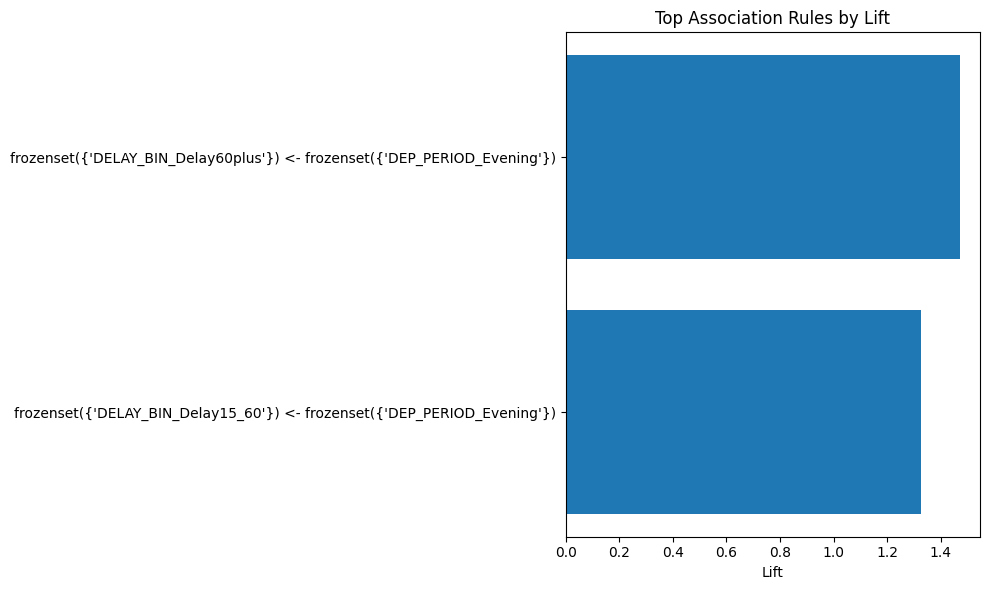

In [39]:
# === PART C Plot 1: Top Rules by Lift ===

# Take top 10 rules sorted by lift
top_rules = rules_delay.sort_values('lift', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.barh(
    top_rules['consequents'].astype(str) + " <- " + top_rules['antecedents'].astype(str),
    top_rules['lift']
)

plt.xlabel("Lift")
plt.title("Top Association Rules by Lift")
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()


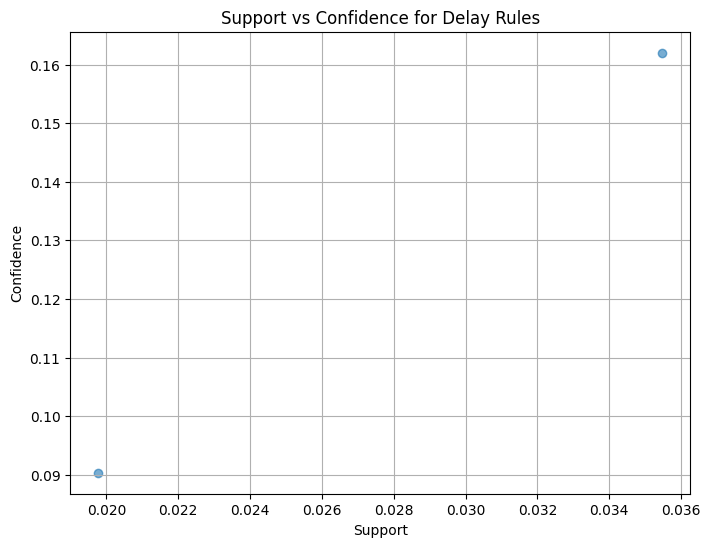

In [40]:
# === PART C Plot 2: Support vs Confidence ===

plt.figure(figsize=(8,6))
plt.scatter(rules_delay['support'], rules_delay['confidence'], alpha=0.6)

plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Support vs Confidence for Delay Rules")
plt.grid(True)
plt.show()


In [38]:
# === PART D: RECOMMENDER SYSTEM (ROBUST VERSION) ===

import warnings
warnings.filterwarnings("ignore")

# 1) Make sure the target exists
if 'DELAYED_OR_CANCELLED' not in df.columns:
    if 'ARR_DELAY' in df.columns:
        df['DELAYED_OR_CANCELLED'] = ((df['ARR_DELAY'] >= 15) | (df.get('CANCELLED', 0) == 1)).astype(int)
    else:
        df['DELAYED_OR_CANCELLED'] = df.get('CANCELLED', 0).fillna(0).astype(int)

# 2) Detect carrier column if available
carrier_candidates = ['OP_CARRIER', 'OP_UNIQUE_CARRIER', 'CARRIER', 'AIRLINE']
carrier_col = None
for c in carrier_candidates:
    if c in df.columns:
        carrier_col = c
        break

print("Detected carrier column:", carrier_col)

# 3) Choose columns for recommender
base_cols = ['ORIGIN', 'DEST', 'DELAYED_OR_CANCELLED']
if carrier_col:
    rec_cols = base_cols + [carrier_col]
else:
    rec_cols = base_cols  # no airline info

rec_cols = [c for c in rec_cols if c in df.columns]  # just in case
print("Columns used for recommender:", rec_cols)

rec = df[rec_cols].dropna()
print("Rows in rec:", rec.shape[0])

# 4) Group and compute stats
group_cols = ['ORIGIN', 'DEST']
if carrier_col:
    group_cols.append(carrier_col)  # route + airline
else:
    pass  # only route-level

stats = (
    rec.groupby(group_cols)
    .agg(
        flights=('DELAYED_OR_CANCELLED', 'size'),
        delay_rate=('DELAYED_OR_CANCELLED', 'mean')
    )
    .reset_index()
)

# Require enough flights for stability
stats = stats[stats['flights'] >= 50]

print("Rows in stats:", stats.shape[0])
print("Sample of stats:")
print(stats.head())

# 5) Define recommend() function

def recommend(origin, dest=None, top_n=5):
    """
    If carrier column exists:
        recommend best airlines for (origin, dest).
    If no carrier column:
        recommend best routes from origin (lowest delay_rate).
    """
    if stats.empty:
        print("No stats available. Check that ORIGIN and DEST exist and there are enough flights.")
        return

    if carrier_col:
        # airline-based recommender for a specific route
        if dest is None:
            print("Please provide both origin and dest, e.g. recommend('JFK','LAX')")
            return

        sub = stats[(stats['ORIGIN'] == origin) & (stats['DEST'] == dest)]
        if sub.empty:
            print(f"No data for route {origin} → {dest}.")
            return

        sub = sub.sort_values('delay_rate')
        print(f"\nBest airlines for {origin} → {dest}:")
        print(sub[[carrier_col, 'flights', 'delay_rate']].head(top_n))

    else:
        # no airline column -> recommend the best routes out of origin
        sub = stats[stats['ORIGIN'] == origin]
        if sub.empty:
            print(f"No data for origin {origin}.")
            return
        sub = sub.sort_values('delay_rate')
        print(f"\nBest routes from {origin} (no airline info in dataset):")
        print(sub[['DEST', 'flights', 'delay_rate']].head(top_n))

# 6) Auto-test on the most frequent origin (and route if carrier is present)

if not stats.empty:
    if carrier_col:
        # pick most common route+airline and use its route for demo
        top = stats.sort_values('flights', ascending=False).iloc[0]
        test_origin = top['ORIGIN']
        test_dest   = top['DEST']
        print("\nTesting recommender with detected route:")
        print(f"Route: {test_origin} → {test_dest}")
        recommend(test_origin, test_dest)
    else:
        # only origin/dest known – pick most common origin
        top = stats.sort_values('flights', ascending=False).iloc[0]
        test_origin = top['ORIGIN']
        print("\nTesting recommender with most frequent origin:")
        print(f"Origin: {test_origin}")
        recommend(test_origin)
else:
    print("stats is empty – cannot recommend.")


Detected carrier column: AIRLINE
Columns used for recommender: ['ORIGIN', 'DEST', 'DELAYED_OR_CANCELLED', 'AIRLINE']
Rows in rec: 2000000
Rows in stats: 8460
Sample of stats:
  ORIGIN DEST                AIRLINE  flights  delay_rate
1    ABE  ATL      Endeavor Air Inc.      165    0.163636
2    ABE  ATL  SkyWest Airlines Inc.       52    0.211538
4    ABE  CLT      PSA Airlines Inc.      312    0.144231
6    ABE  DTW      Endeavor Air Inc.       81    0.061728
7    ABE  DTW  SkyWest Airlines Inc.      124    0.209677

Testing recommender with detected route:
Route: HNL → OGG

Best airlines for HNL → OGG:
                     AIRLINE  flights  delay_rate
6866  Hawaiian Airlines Inc.     2328    0.147337
6867  Southwest Airlines Co.      675    0.151111


In [41]:
# Find most frequent route for plotting
top_route = stats.sort_values('flights', ascending=False).iloc[0]
print(top_route)


ORIGIN                           HNL
DEST                             OGG
AIRLINE       Hawaiian Airlines Inc.
flights                         2328
delay_rate                  0.147337
Name: 6866, dtype: object


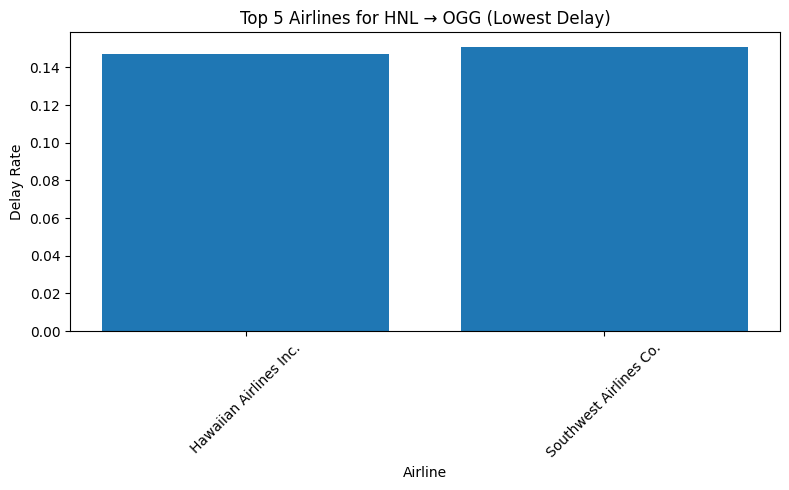

In [42]:
# === PART D Plot 1: Best Airlines on a Route ===

origin = top_route['ORIGIN']
dest   = top_route['DEST']

subset = stats[(stats['ORIGIN']==origin) & (stats['DEST']==dest)]
subset = subset.sort_values('delay_rate').head(5)

plt.figure(figsize=(8,5))
plt.bar(subset[carrier_col], subset['delay_rate'])

plt.ylabel("Delay Rate")
plt.xlabel("Airline")
plt.title(f"Top 5 Airlines for {origin} → {dest} (Lowest Delay)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


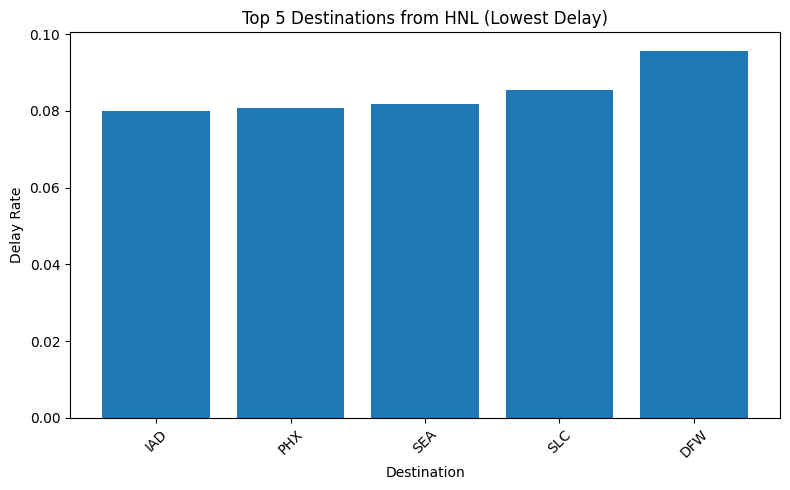

In [43]:
best_routes = stats[stats['ORIGIN']==origin].sort_values('delay_rate').head(5)

plt.figure(figsize=(8,5))
plt.bar(best_routes['DEST'], best_routes['delay_rate'])

plt.ylabel("Delay Rate")
plt.xlabel("Destination")
plt.title(f"Top 5 Destinations from {origin} (Lowest Delay)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


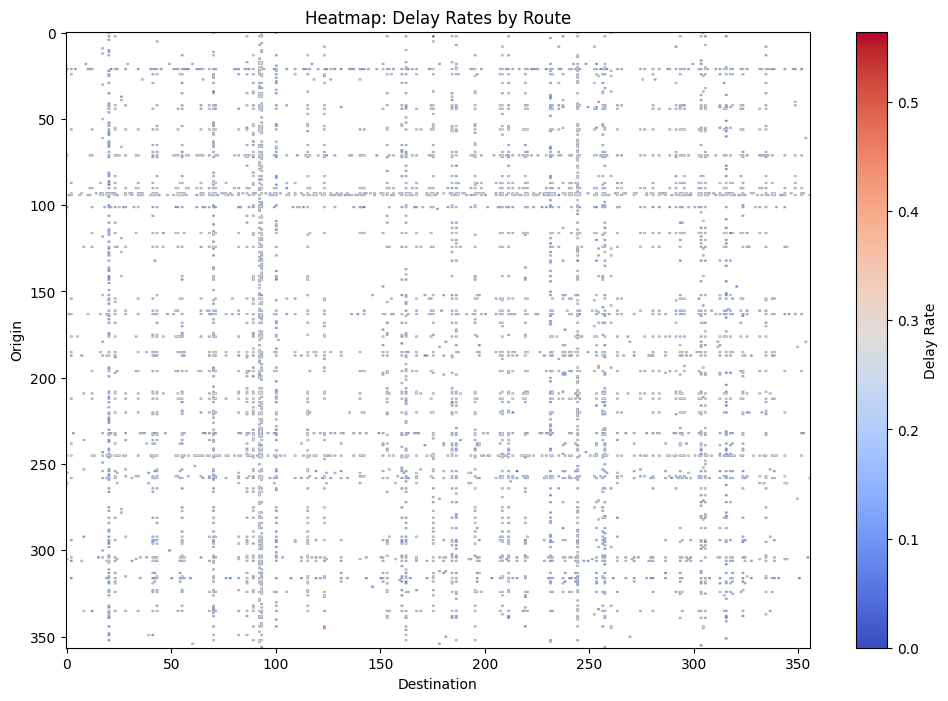

In [44]:
# === PART D Plot 2: Route Delay Heatmap ===

# Create pivot table: origin x dest
heat = stats.pivot_table(
    index='ORIGIN',
    columns='DEST',
    values='delay_rate'
)

plt.figure(figsize=(12,8))
plt.imshow(heat, aspect='auto', cmap='coolwarm')
plt.colorbar(label="Delay Rate")

plt.xlabel("Destination")
plt.ylabel("Origin")
plt.title("Heatmap: Delay Rates by Route")
plt.show()
